# Comparative Analysis Notebook: Classical vs Deep Learning Video Classification

Here we are generating the full **comparative analysis**:

1. **Performance Comparison Table** (all metrics, highlight best)
2. **Computational Efficiency** (training time, inference time, GPU memory, model size)
3. **Data Efficiency** (learning curves vs training data size)
4. **Strengths & Limitations** (interpretability, robustness, when each excels)
5. **Feature/Representation Analysis**
   - Classical: feature importance ranking
   - Deep learning: attention / learned feature visualization
   - t-SNE feature-space visualization for both


---

## 0) Install dependencies (if missing)

```bash
pip install opencv-python numpy pandas scikit-learn matplotlib seaborn tqdm joblib umap-learn scikit-image torch torchvision
```


In [2]:
import os, time, math, json, random
import numpy as np
import pandas as pd
from tqdm import tqdm

# Classical
import cv2
from collections import Counter

# ML
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_curve, auc, f1_score
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

# Features
from scipy.stats import skew
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from skimage.filters import gabor

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('DEVICE:', DEVICE)


DEVICE: cuda


In [3]:
#Paths
DATA_ROOT_CLASSICAL = r"Dataset"      # Classical Learning Splits Dataset
DATA_ROOT_DEEP      = r"Dataset_DL"   # Deep Learning Splits dataset

SPLITS_DIR_NAME = 'splits'
TRAIN_TXT = 'train.txt'
VAL_TXT   = 'val.txt'
TEST_TXT  = 'test.txt'

# Classical frame size
RESIZE_W, RESIZE_H = 320, 240

# Deep frame size
IMG_SIZE = 224

# Sampling
CLASSICAL_SAMPLING = 'uniform'  # uniform | random | dense
DEEP_SAMPLING      = 'uniform'  # uniform | random | dense

# Speed knobs
FAST_MODE = True
DISABLE_HORN_SCHUNCK_IF_FAST = True

# Cache
CACHE_DIR = 'cache_comp_analysis'
os.makedirs(CACHE_DIR, exist_ok=True)

print('DATA_ROOT_CLASSICAL:', DATA_ROOT_CLASSICAL)
print('DATA_ROOT_DEEP     :', DATA_ROOT_DEEP)
print('CACHE_DIR         :', CACHE_DIR)


DATA_ROOT_CLASSICAL: Dataset
DATA_ROOT_DEEP     : Dataset_DL
CACHE_DIR         : cache_comp_analysis


---

## 1) Shared utilities


In [4]:
def read_split_file(path):
    rows = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rel_path, label = line.split()
            rows.append((rel_path.replace('\\', '/'), int(label)))
    return rows

def get_split_paths(root):
    splits_dir = os.path.join(root, SPLITS_DIR_NAME)
    return (
        os.path.join(splits_dir, TRAIN_TXT),
        os.path.join(splits_dir, VAL_TXT),
        os.path.join(splits_dir, TEST_TXT),
    )

def load_splits(root):
    tr, va, te = get_split_paths(root)
    train_rows = read_split_file(tr)
    val_rows   = read_split_file(va)
    test_rows  = read_split_file(te)
    labels = [y for _, y in (train_rows + val_rows + test_rows)]
    n_classes = len(sorted(set(labels)))
    return train_rows, val_rows, test_rows, n_classes

def now():
    return time.perf_counter()

def sizeof_file_mb(path):
    return os.path.getsize(path) / (1024**2)

def torch_model_size_mb(model, fp32=True):
    params = sum(p.numel() for p in model.parameters())
    bytes_per = 4 if fp32 else 2
    return params * bytes_per / (1024**2), int(params)

def highlight_best(df, metric_cols, higher_is_better=None):
    # Returns a Styler that highlights best value in each metric column
    higher_is_better = higher_is_better or {c: True for c in metric_cols}

    def _hl(col):
        hib = higher_is_better.get(col.name, True)
        best = col.max() if hib else col.min()
        return ['font-weight: bold; background-color: #dff0d8' if v == best else '' for v in col]

    return df.style.apply(_hl, subset=metric_cols)

def plot_confmat(y_true, y_pred, n_classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'C{i}' for i in range(n_classes)],
                yticklabels=[f'C{i}' for i in range(n_classes)])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def multiclass_auc_ovr(y_true, y_score, n_classes):
    y_bin = label_binarize(y_true, classes=np.arange(n_classes))
    aucs = []
    for c in range(n_classes):
        fpr, tpr, _ = roc_curve(y_bin[:, c], y_score[:, c])
        aucs.append(auc(fpr, tpr))
    return float(np.mean(aucs)), aucs


---

## 2) Classical pipeline


In [5]:
def load_video_opencv(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f'Cannot open video: {video_path}')
    fps = cap.get(cv2.CAP_PROP_FPS) or 0
    nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) or 0)
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) or 0)
    cap.release()
    return fps, nframes, w, h

def read_all_frames(video_path, max_frames=None):
    cap = cv2.VideoCapture(video_path)
    frames = []
    i = 0
    while True:
        ok, fr = cap.read()
        if not ok:
            break
        frames.append(fr)
        i += 1
        if max_frames and i >= max_frames:
            break
    cap.release()
    return frames

def uniform_sampling(frames, fps, target_fps=1.0):
    if fps <= 0:
        stride = max(1, len(frames)//10)
    else:
        stride = max(1, int(round(fps / target_fps)))
    return frames[::stride], stride

def random_sampling(frames, k=16):
    rng = np.random.default_rng(SEED)
    if len(frames) <= k:
        return frames
    idx = rng.choice(len(frames), size=k, replace=False)
    idx = np.sort(idx)
    return [frames[i] for i in idx]

def enhance_frame(frame_bgr):
    den = cv2.fastNlMeansDenoisingColored(frame_bgr, None, 5, 5, 7, 21)
    ga = cv2.GaussianBlur(den, (0,0), 1.0)
    sharp = cv2.addWeighted(den, 1.5, ga, -0.5, 0)
    return sharp

def preprocess_frame_classical(frame_bgr):
    fr = cv2.resize(frame_bgr, (RESIZE_W, RESIZE_H), interpolation=cv2.INTER_AREA)
    fr = enhance_frame(fr)
    return fr

def sample_frames_from_video(video_path, strategy='uniform', target_fps=1.0, k_random=16, max_frames_dense=120):
    fps, nframes, w, h = load_video_opencv(video_path)
    frames = read_all_frames(video_path)

    if strategy == 'dense':
        if FAST_MODE:
            frames = frames[:max_frames_dense]
        sampled = frames
    elif strategy == 'random':
        sampled = random_sampling(frames, k=k_random)
    else:
        sampled, _ = uniform_sampling(frames, fps, target_fps=target_fps)

    return sampled, fps


In [6]:
# Classical features

def color_hist_rgb(frame_bgr, bins=16):
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    feats = []
    for ch in range(3):
        hist = cv2.calcHist([rgb], [ch], None, [bins], [0,256]).flatten()
        hist = hist / (hist.sum() + 1e-9)
        feats.append(hist)
    return np.concatenate(feats).astype(np.float32)

def color_hist_hsv(frame_bgr, bins=16):
    hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)
    feats = []
    for ch in range(3):
        hist = cv2.calcHist([hsv], [ch], None, [bins], [0,256]).flatten()
        hist = hist / (hist.sum() + 1e-9)
        feats.append(hist)
    return np.concatenate(feats).astype(np.float32)

def color_moments(frame_bgr):
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
    feats = []
    for ch in range(3):
        v = rgb[:,:,ch].reshape(-1)
        feats.extend([v.mean(), v.var(), skew(v)])
    return np.array(feats, dtype=np.float32)

def avg_color(frame_bgr):
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
    return rgb.reshape(-1,3).mean(axis=0).astype(np.float32)

def glcm_features(frame_bgr, distances=(1,2), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    gray_q = (gray // 16).astype(np.uint8)
    glcm = graycomatrix(gray_q, distances=list(distances), angles=list(angles), levels=16, symmetric=True, normed=True)
    props = ['contrast','dissimilarity','homogeneity','energy','correlation','ASM']
    feats = []
    for p in props:
        feats.extend(graycoprops(glcm, p).flatten())
    return np.array(feats, dtype=np.float32)

def lbp_features(frame_bgr, P=8, R=1, bins=32):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins), density=True)
    return hist.astype(np.float32)

def gabor_features(frame_bgr, freqs=(0.2, 0.4), thetas=(0, np.pi/4, np.pi/2)):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)/255.0
    feats = []
    for f in freqs:
        for t in thetas:
            real, imag = gabor(gray, frequency=f, theta=t)
            mag = np.sqrt(real**2 + imag**2)
            feats.extend([mag.mean(), mag.var()])
    return np.array(feats, dtype=np.float32)

def edge_histogram(frame_bgr, bins=16):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 80, 160)
    proj = edges.sum(axis=0).astype(np.float32)
    hist, _ = np.histogram(proj, bins=bins, density=True)
    return hist.astype(np.float32)

def contour_features(frame_bgr):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 80, 160)
    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return np.zeros(6, dtype=np.float32)
    areas = np.array([cv2.contourArea(c) for c in cnts], dtype=np.float32)
    peris = np.array([cv2.arcLength(c, True) for c in cnts], dtype=np.float32)
    feats = [float(len(cnts)), float(areas.mean()), float(areas.var()), float(peris.mean()), float(peris.var()), float(areas.max())]
    return np.array(feats, dtype=np.float32)

def hog_features(frame_bgr):
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    feat = hog(gray, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2),
               block_norm='L2-Hys', visualize=False, feature_vector=True)
    return feat.astype(np.float32)

def temporal_stats(feature_seq_2d):
    if feature_seq_2d is None or len(feature_seq_2d) == 0:
        return None
    x = np.asarray(feature_seq_2d, dtype=np.float32)
    return np.concatenate([x.mean(axis=0), x.std(axis=0), x.min(axis=0), x.max(axis=0)]).astype(np.float32)

def frame_to_frame_variation(feature_seq_2d):
    if feature_seq_2d is None or len(feature_seq_2d) < 2:
        return np.zeros(4, dtype=np.float32)
    x = np.asarray(feature_seq_2d, dtype=np.float32)
    dif = np.abs(x[1:] - x[:-1]).mean(axis=1)
    return np.array([dif.mean(), dif.std(), dif.min(), dif.max()], dtype=np.float32)

def frame_diff_features(frames_bgr, bins=16):
    if len(frames_bgr) < 2:
        return np.zeros(8 + bins, dtype=np.float32)
    diffs = []
    mags = []
    for i in range(1, len(frames_bgr)):
        g1 = cv2.cvtColor(frames_bgr[i-1], cv2.COLOR_BGR2GRAY).astype(np.float32)
        g2 = cv2.cvtColor(frames_bgr[i],   cv2.COLOR_BGR2GRAY).astype(np.float32)
        d = np.abs(g2 - g1)
        diffs.append(d)
        mags.append(d.mean())
    mags = np.array(mags, dtype=np.float32)
    hist, _ = np.histogram(np.concatenate([d.ravel() for d in diffs]), bins=bins, range=(0,255), density=True)
    stats = np.array([
        mags.mean(), mags.std(), mags.min(), mags.max(),
        np.percentile(mags, 25), np.percentile(mags, 50), np.percentile(mags, 75),
        float(len(frames_bgr))
    ], dtype=np.float32)
    return np.concatenate([stats, hist.astype(np.float32)]).astype(np.float32)

def lucas_kanade_sparse(frames_bgr, max_corners=200):
    if len(frames_bgr) < 2:
        return np.zeros(10, dtype=np.float32)
    prev = cv2.cvtColor(frames_bgr[0], cv2.COLOR_BGR2GRAY)
    nxt  = cv2.cvtColor(frames_bgr[1], cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(prev, maxCorners=max_corners, qualityLevel=0.01, minDistance=7)
    if p0 is None:
        return np.zeros(10, dtype=np.float32)
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev, nxt, p0, None)
    good0 = p0[st==1]
    good1 = p1[st==1]
    flow = good1 - good0
    mag = np.linalg.norm(flow, axis=1)
    ang = np.arctan2(flow[:,1], flow[:,0])
    feats = np.array([
        mag.mean(), mag.std(), mag.min(), mag.max(),
        np.cos(ang).mean(), np.sin(ang).mean(),
        float(len(mag)), float(np.median(mag)),
        float(np.percentile(mag, 75)), float(np.percentile(mag, 25))
    ], dtype=np.float32)
    return feats

def horn_schunck_dense_features(frames_bgr, mag_bins=16, ang_bins=16):
    # Disabled placeholder (keeps vector length stable)
    return np.zeros(4 + mag_bins + ang_bins + 2, dtype=np.float32)

def extract_frame_features(frame_bgr):
    f_color = np.concatenate([color_hist_rgb(frame_bgr), color_hist_hsv(frame_bgr), color_moments(frame_bgr), avg_color(frame_bgr)])
    f_tex = np.concatenate([glcm_features(frame_bgr), lbp_features(frame_bgr), gabor_features(frame_bgr)])
    f_shape = np.concatenate([edge_histogram(frame_bgr), contour_features(frame_bgr), hog_features(frame_bgr)])
    return np.concatenate([f_color, f_tex, f_shape]).astype(np.float32)

def extract_video_features(video_abs_path, sampling='uniform'):
    frames, fps = sample_frames_from_video(video_abs_path, strategy=sampling, target_fps=1.0, k_random=16,
                                          max_frames_dense=120 if FAST_MODE else 500)
    frames = [preprocess_frame_classical(f) for f in frames]

    frame_feats = [extract_frame_features(f) for f in frames] if len(frames) else None
    frame_feats = np.vstack(frame_feats) if frame_feats is not None and len(frame_feats) else None

    temp = temporal_stats(frame_feats) if frame_feats is not None else None
    var  = frame_to_frame_variation(frame_feats) if frame_feats is not None else np.zeros(4, dtype=np.float32)

    subset = frames[:10]
    fd_feat = frame_diff_features(subset)
    lk_feat = lucas_kanade_sparse(subset[:2])

    if FAST_MODE and DISABLE_HORN_SCHUNCK_IF_FAST:
        hs_feat = horn_schunck_dense_features(subset[:2])
    else:
        hs_feat = horn_schunck_dense_features(subset[:2])

    if temp is None:
        dummy = np.zeros((RESIZE_H, RESIZE_W, 3), dtype=np.uint8)
        dfeat = extract_frame_features(dummy)
        temp = np.zeros(4 * len(dfeat), dtype=np.float32)

    video_vec = np.concatenate([temp, var, fd_feat, lk_feat, hs_feat]).astype(np.float32)
    return np.nan_to_num(video_vec, nan=0.0, posinf=0.0, neginf=0.0)


In [7]:
def build_Xy(rows, root, sampling='uniform', cache_name=None, limit=None):
    if cache_name:
        cache_path = os.path.join(CACHE_DIR, cache_name)
        if os.path.exists(cache_path):
            data = np.load(cache_path, allow_pickle=True)
            return data['X'], data['y']

    X, y = [], []
    t0 = time.time()
    for i, (rel, lab) in enumerate(rows):
        if limit and i >= limit:
            break
        abs_path = os.path.join(root, rel)
        feats = extract_video_features(abs_path, sampling=sampling)
        X.append(feats)
        y.append(lab)
        if (i+1) % 10 == 0:
            print(f'[{sampling}] processed {i+1}/{len(rows)}')

    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    print(f'Built X,y: X={X.shape}, y={y.shape}, time={time.time()-t0:.1f}s')

    if cache_name:
        np.savez_compressed(os.path.join(CACHE_DIR, cache_name), X=X, y=y)

    return X, y

def prep_and_pca(X_train, X_val, X_test, pca_var=0.95):
    prep = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', StandardScaler())])
    Xtr_s = prep.fit_transform(X_train)
    Xva_s = prep.transform(X_val)
    Xte_s = prep.transform(X_test)

    pca = PCA(n_components=pca_var, random_state=SEED)
    Xtr_p = pca.fit_transform(Xtr_s)
    Xva_p = pca.transform(Xva_s)
    Xte_p = pca.transform(Xte_s)

    print('PCA reduced:', X_train.shape, '->', Xtr_p.shape)
    return prep, pca, Xtr_p, Xva_p, Xte_p


In [9]:
import joblib

def eval_classifier(model, X_test, y_test, n_classes, title=''):
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)
    else:
        dec = model.decision_function(X_test)
        exp = np.exp(dec - dec.max(axis=1, keepdims=True))
        y_score = exp / (exp.sum(axis=1, keepdims=True) + 1e-9)

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
    macro_auc, _ = multiclass_auc_ovr(y_test, y_score, n_classes)

    print('===', title, '===')
    print('Accuracy:', acc)
    print('Macro P/R/F1:', prec, rec, f1)
    print('Macro AUC:', macro_auc)
    plot_confmat(y_test, y_pred, n_classes, title=title + ' - Confusion Matrix')

    return {
        'accuracy': float(acc),
        'precision': float(prec),
        'recall': float(rec),
        'f1': float(f1),
        'macro_auc': float(macro_auc)
    }


def train_classical_models(Xtr_p, ytr, Xte_p, yte, n_classes):
    results = {}

    # SVM
    svm_grid = {'C':[0.1,1,10], 'kernel':['linear','rbf'], 'gamma':['scale',0.01,0.001]}
    svm = SVC(probability=True, random_state=SEED)
    t0 = time.time()
    gs = GridSearchCV(svm, svm_grid, cv=3, n_jobs=-1, verbose=1)
    gs.fit(Xtr_p, ytr)
    train_t = time.time() - t0
    best_svm = gs.best_estimator_

    t1 = time.time(); _ = best_svm.predict(Xte_p); infer_total = time.time()-t1
    met = eval_classifier(best_svm, Xte_p, yte, n_classes, title='Classical - SVM (best)')

    path = os.path.join(CACHE_DIR, 'svm_model.joblib')
    joblib.dump(best_svm, path)
    results['Classical-SVM'] = {**met, 'train_time_s': float(train_t),
                               'infer_time_s_per_video': float(infer_total/len(yte)),
                               'model_size_mb': float(sizeof_file_mb(path)),
                               'gpu_mem_mb': 0.0, 'params': np.nan}

    # RF
    rf_grid = {'n_estimators':[200,400], 'max_depth':[None,20,40], 'min_samples_split':[2,5]}
    rf = RandomForestClassifier(random_state=SEED, n_jobs=-1)
    t0 = time.time()
    gs_rf = GridSearchCV(rf, rf_grid, cv=3, n_jobs=-1, verbose=1)
    gs_rf.fit(Xtr_p, ytr)
    train_t = time.time() - t0
    best_rf = gs_rf.best_estimator_

    t1 = time.time(); _ = best_rf.predict(Xte_p); infer_total = time.time()-t1
    met = eval_classifier(best_rf, Xte_p, yte, n_classes, title='Classical - RF (best)')

    path = os.path.join(CACHE_DIR, 'rf_model.joblib')
    joblib.dump(best_rf, path)

    # importance in PCA space
    imp = best_rf.feature_importances_
    topk = np.argsort(imp)[::-1][:20]
    plt.figure(figsize=(8,3))
    plt.bar(np.arange(len(topk)), imp[topk])
    plt.title('RF Feature Importance (Top 20 PCA components)')
    plt.tight_layout(); plt.show()

    results['Classical-RF'] = {**met, 'train_time_s': float(train_t),
                              'infer_time_s_per_video': float(infer_total/len(yte)),
                              'model_size_mb': float(sizeof_file_mb(path)),
                              'gpu_mem_mb': 0.0, 'params': np.nan}

    # kNN
    knn_grid = {'n_neighbors':[3,5,7,9,11,15], 'weights':['uniform','distance'], 'metric':['euclidean','manhattan']}
    knn = KNeighborsClassifier()
    t0 = time.time()
    gs_knn = GridSearchCV(knn, knn_grid, cv=3, n_jobs=-1, verbose=1)
    gs_knn.fit(Xtr_p, ytr)
    train_t = time.time() - t0
    best_knn = gs_knn.best_estimator_

    t1 = time.time(); _ = best_knn.predict(Xte_p); infer_total = time.time()-t1
    met = eval_classifier(best_knn, Xte_p, yte, n_classes, title='Classical - kNN (best)')

    path = os.path.join(CACHE_DIR, 'knn_model.joblib')
    joblib.dump(best_knn, path)

    results['Classical-kNN'] = {**met, 'train_time_s': float(train_t),
                               'infer_time_s_per_video': float(infer_total/len(yte)),
                               'model_size_mb': float(sizeof_file_mb(path)),
                               'gpu_mem_mb': 0.0, 'params': np.nan}

    return results


---

## 3) Deep Learning pipeline


In [10]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)
imgnet_norm = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)

def sanitize_tensor(x):
    return torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)

def load_video_cv2(video_path, max_frames=None):
    cap = cv2.VideoCapture(video_path)
    frames = []
    ok = True
    while ok:
        ok, fr = cap.read()
        if not ok:
            break
        frames.append(fr)
        if max_frames and len(frames) >= max_frames:
            break
    cap.release()
    return frames

def resize_frames(frames, size=224):
    return [cv2.resize(fr, (size, size), interpolation=cv2.INTER_AREA) for fr in frames]

def uniform_sample(frames, num_frames=32):
    if len(frames) == 0:
        return []
    idxs = np.linspace(0, len(frames)-1, num_frames, dtype=int)
    return [frames[i] for i in idxs]

def random_sample(frames, num_frames=32):
    if len(frames) == 0:
        return []
    rng = np.random.default_rng(SEED)
    idxs = rng.choice(len(frames), size=min(num_frames, len(frames)), replace=False)
    idxs = np.sort(idxs)
    return [frames[i] for i in idxs]

class FrameDataset2D(Dataset):
    def __init__(self, rows, root, num_frames=32, sampling='uniform', enhance=True, use_imagenet_norm=True):
        self.rows = rows
        self.root = root
        self.num_frames = num_frames
        self.sampling = sampling
        self.enhance = enhance
        self.to_tensor = transforms.ToTensor()
        self.norm = imgnet_norm if use_imagenet_norm else None

    def __len__(self):
        return len(self.rows)

    def _sample(self, frames):
        if self.sampling == 'uniform':
            return uniform_sample(frames, self.num_frames)
        if self.sampling == 'random':
            return random_sample(frames, self.num_frames)
        return frames

    def __getitem__(self, idx):
        rel, label = self.rows[idx]
        abs_path = os.path.join(self.root, rel)
        frames = load_video_cv2(abs_path, max_frames=400)
        frames = resize_frames(frames, IMG_SIZE)
        frames = self._sample(frames)
        if self.enhance:
            frames = [enhance_frame(fr) for fr in frames]

        tensor_frames = []
        for fr in frames:
            fr_rgb = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            t = self.to_tensor(fr_rgb)
            if self.norm:
                t = self.norm(t)
            tensor_frames.append(t)

        x = torch.stack(tensor_frames, dim=0)  # (T,C,H,W)
        x = sanitize_tensor(x)
        y = torch.tensor(label, dtype=torch.long)
        return x, y

class ClipDataset3D(Dataset):
    def __init__(self, rows, root, clip_len=16, sampling='uniform', enhance=True, use_imagenet_norm=True):
        self.rows = rows
        self.root = root
        self.clip_len = clip_len
        self.sampling = sampling
        self.enhance = enhance
        self.to_tensor = transforms.ToTensor()
        self.norm = imgnet_norm if use_imagenet_norm else None

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, idx):
        rel, label = self.rows[idx]
        abs_path = os.path.join(self.root, rel)
        frames = load_video_cv2(abs_path, max_frames=400)
        frames = resize_frames(frames, IMG_SIZE)
        frames = random_sample(frames, self.clip_len) if self.sampling == 'random' else uniform_sample(frames, self.clip_len)
        if self.enhance:
            frames = [enhance_frame(fr) for fr in frames]

        clip = []
        for fr in frames:
            fr_rgb = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
            t = self.to_tensor(fr_rgb)
            if self.norm:
                t = self.norm(t)
            clip.append(t)

        clip = torch.stack(clip, dim=1)  # (C,T,H,W)
        clip = sanitize_tensor(clip)
        y = torch.tensor(label, dtype=torch.long)
        return clip, y


In [11]:
class TemporalAttentionPool(nn.Module):
    def __init__(self, feat_dim):
        super().__init__()
        self.fc1 = nn.Linear(feat_dim, feat_dim // 2)
        self.fc2 = nn.Linear(feat_dim // 2, 1)

    def forward(self, feats):
        h = torch.tanh(self.fc1(feats))
        scores = self.fc2(h).squeeze(-1)
        attn = torch.softmax(scores, dim=1)
        pooled = torch.sum(feats * attn.unsqueeze(-1), dim=1)
        return pooled, attn

class EfficientNetTemporal(nn.Module):
    def __init__(self, num_classes, pooling='avg', dropout=0.3, fine_tune_last_n=2):
        super().__init__()
        weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
        self.backbone = torchvision.models.efficientnet_b0(weights=weights)
        self.backbone.classifier = nn.Identity()
        self.feat_dim = 1280
        self.pooling = pooling
        if pooling == 'attn':
            self.attn_pool = TemporalAttentionPool(self.feat_dim)
        self.ln = nn.LayerNorm(self.feat_dim)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(self.feat_dim, num_classes)

        for p in self.backbone.parameters():
            p.requires_grad = False
        for block in list(self.backbone.features.children())[-fine_tune_last_n:]:
            for p in block.parameters():
                p.requires_grad = True

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        feats = self.backbone(x)
        feats = feats.view(B, T, -1)

        if self.pooling == 'avg':
            pooled = feats.mean(dim=1); attn = None
        elif self.pooling == 'max':
            pooled = feats.max(dim=1).values; attn = None
        elif self.pooling == 'attn':
            pooled, attn = self.attn_pool(feats)
        else:
            raise ValueError('pooling must be avg/max/attn')

        pooled = self.ln(pooled)
        pooled = self.drop(pooled)
        logits = self.fc(pooled)
        return logits, attn

def build_r3d18(num_classes):
    weights = torchvision.models.video.R3D_18_Weights.DEFAULT
    model = torchvision.models.video.r3d_18(weights=weights)
    in_feats = model.fc.in_features
    model.fc = nn.Sequential(nn.LayerNorm(in_feats), nn.Dropout(0.3), nn.Linear(in_feats, num_classes))

    for p in model.parameters():
        p.requires_grad = False
    for p in model.layer4.parameters():
        p.requires_grad = True
    for p in model.fc.parameters():
        p.requires_grad = True

    return model


In [12]:
class EarlyStopper:
    def __init__(self, patience=4, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.count = 0

    def step(self, val_metric):
        if self.best is None or val_metric > self.best + self.min_delta:
            self.best = val_metric
            self.count = 0
            return False
        self.count += 1
        return self.count >= self.patience


def run_epoch_2d(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss = 0.0
    ys, ps = [], []
    start = now()
    for x, y in tqdm(loader, desc='train2D' if is_train else 'eval2D', leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)
        if is_train:
            optimizer.zero_grad()
        logits, _ = model(x)
        loss = F.cross_entropy(logits, y)
        if is_train:
            loss.backward(); optimizer.step()
        total_loss += loss.item() * x.size(0)
        ys.extend(y.detach().cpu().tolist())
        ps.extend(torch.argmax(logits, dim=1).detach().cpu().tolist())
    dur = now() - start
    return total_loss/len(loader.dataset), accuracy_score(ys, ps), dur


def run_epoch_3d(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss = 0.0
    ys, ps = [], []
    start = now()
    for x, y in tqdm(loader, desc='train3D' if is_train else 'eval3D', leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)
        if is_train:
            optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        if is_train:
            loss.backward(); optimizer.step()
        total_loss += loss.item() * x.size(0)
        ys.extend(y.detach().cpu().tolist())
        ps.extend(torch.argmax(logits, dim=1).detach().cpu().tolist())
    dur = now() - start
    return total_loss/len(loader.dataset), accuracy_score(ys, ps), dur

@torch.no_grad()
def eval_deep_2d(model, rows, root, batch=2):
    ds = FrameDataset2D(rows, root, num_frames=32, sampling=DEEP_SAMPLING)
    dl = DataLoader(ds, batch_size=batch, shuffle=False, num_workers=0)
    model.eval()
    ys, preds, probs = [], [], []
    start = now()
    for x, y in tqdm(dl, desc='Eval2D', leave=False):
        x = x.to(DEVICE)
        logits, _ = model(x)
        p = torch.softmax(logits, dim=1)
        probs.append(p.cpu().numpy())
        preds.extend(torch.argmax(p, dim=1).cpu().tolist())
        ys.extend(y.tolist())
    total = now() - start
    probs = np.concatenate(probs, axis=0)
    return np.array(ys), np.array(preds), probs, total/len(rows)

@torch.no_grad()
def eval_deep_3d(model, rows, root, batch=2):
    ds = ClipDataset3D(rows, root, clip_len=16, sampling=DEEP_SAMPLING)
    dl = DataLoader(ds, batch_size=batch, shuffle=False, num_workers=0)
    model.eval()
    ys, preds, probs = [], [], []
    start = now()
    for x, y in tqdm(dl, desc='Eval3D', leave=False):
        x = x.to(DEVICE)
        logits = model(x)
        p = torch.softmax(logits, dim=1)
        probs.append(p.cpu().numpy())
        preds.extend(torch.argmax(p, dim=1).cpu().tolist())
        ys.extend(y.tolist())
    total = now() - start
    probs = np.concatenate(probs, axis=0)
    return np.array(ys), np.array(preds), probs, total/len(rows)


def gpu_memory_report_mb():
    if not torch.cuda.is_available():
        return 0.0
    return float(torch.cuda.max_memory_allocated()/(1024**2))


def deep_metrics_from_probs(y_true, y_pred, y_prob, n_classes):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    macro_auc, _ = multiclass_auc_ovr(y_true, y_prob, n_classes)
    return {'accuracy': float(acc), 'precision': float(prec), 'recall': float(rec), 'f1': float(f1), 'macro_auc': float(macro_auc)}


def train_deep_2d_variant(train_rows, val_rows, root, n_classes, pooling='max', epochs=6, lr=1e-4, batch=2):
    train_dl = DataLoader(FrameDataset2D(train_rows, root, num_frames=32, sampling=DEEP_SAMPLING), batch_size=batch, shuffle=True)
    val_dl   = DataLoader(FrameDataset2D(val_rows, root,   num_frames=32, sampling=DEEP_SAMPLING), batch_size=batch, shuffle=False)

    model = EfficientNetTemporal(n_classes, pooling=pooling).to(DEVICE)
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.StepLR(optim, step_size=max(2, epochs//2), gamma=0.5)
    stopper = EarlyStopper(patience=4)

    best_val = -1
    best_path = os.path.join(CACHE_DIR, f'best_2d_{pooling}.pt')
    total_train_time = 0.0

    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_t = run_epoch_2d(model, train_dl, optimizer=optim)
        va_loss, va_acc, va_t = run_epoch_2d(model, val_dl, optimizer=None)
        sched.step()
        total_train_time += tr_t
        print(f'[2D-{pooling}] ep {ep:02d} tr_acc={tr_acc:.3f} va_acc={va_acc:.3f}')
        if va_acc > best_val:
            best_val = va_acc
            torch.save(model.state_dict(), best_path)
        if stopper.step(va_acc):
            print('Early stopping'); break

    return best_path, float(total_train_time)


def train_deep_3d(train_rows, val_rows, root, n_classes, epochs=6, lr=1e-4, batch=2):
    train_dl = DataLoader(ClipDataset3D(train_rows, root, clip_len=16, sampling=DEEP_SAMPLING), batch_size=batch, shuffle=True)
    val_dl   = DataLoader(ClipDataset3D(val_rows, root,   clip_len=16, sampling=DEEP_SAMPLING), batch_size=batch, shuffle=False)

    model = build_r3d18(n_classes).to(DEVICE)
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.StepLR(optim, step_size=max(2, epochs//2), gamma=0.5)
    stopper = EarlyStopper(patience=4)

    best_val = -1
    best_path = os.path.join(CACHE_DIR, 'best_3d_r3d18.pt')
    total_train_time = 0.0

    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_t = run_epoch_3d(model, train_dl, optimizer=optim)
        va_loss, va_acc, va_t = run_epoch_3d(model, val_dl, optimizer=None)
        sched.step()
        total_train_time += tr_t
        print(f'[3D-R3D18] ep {ep:02d} tr_acc={tr_acc:.3f} va_acc={va_acc:.3f}')
        if va_acc > best_val:
            best_val = va_acc
            torch.save(model.state_dict(), best_path)
        if stopper.step(va_acc):
            print('Early stopping'); break

    return best_path, float(total_train_time)


---

## 4) Run experiments + build final comparison table


In [13]:
# Load splits
train_c, val_c, test_c, n_classes_c = load_splits(DATA_ROOT_CLASSICAL)
train_d, val_d, test_d, n_classes_d = load_splits(DATA_ROOT_DEEP)

print('Classical splits:', len(train_c), len(val_c), len(test_c), 'classes:', n_classes_c)
print('Deep splits     :', len(train_d), len(val_d), len(test_d), 'classes:', n_classes_d)

N_CLASSES = min(n_classes_c, n_classes_d)


Classical splits: 54 12 9 classes: 3
Deep splits     : 277 59 60 classes: 3


[uniform] processed 10/54
[uniform] processed 20/54
[uniform] processed 30/54
[uniform] processed 40/54
[uniform] processed 50/54
Built X,y: X=(54, 163828), y=(54,), time=71.3s
[uniform] processed 10/12
Built X,y: X=(12, 163828), y=(12,), time=15.3s
Built X,y: X=(9, 163828), y=(9,), time=11.6s
PCA reduced: (54, 163828) -> (54, 46)
Fitting 3 folds for each of 18 candidates, totalling 54 fits
=== Classical - SVM (best) ===
Accuracy: 0.6666666666666666
Macro P/R/F1: 0.6666666666666666 0.6666666666666666 0.6571428571428571
Macro AUC: 0.851851851851852


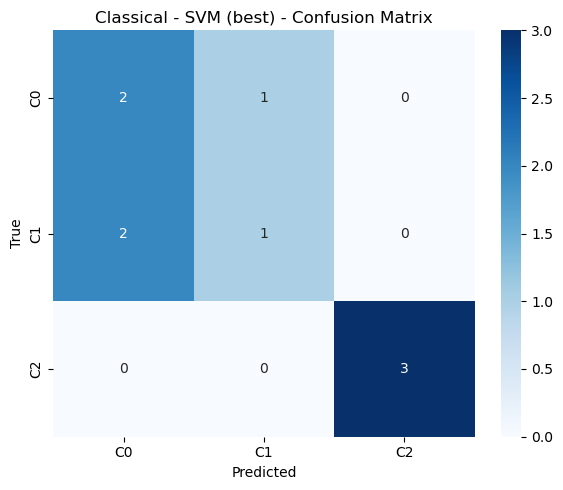

Fitting 3 folds for each of 12 candidates, totalling 36 fits
=== Classical - RF (best) ===
Accuracy: 0.7777777777777778
Macro P/R/F1: 0.8055555555555555 0.7777777777777777 0.7746031746031746
Macro AUC: 0.8981481481481483


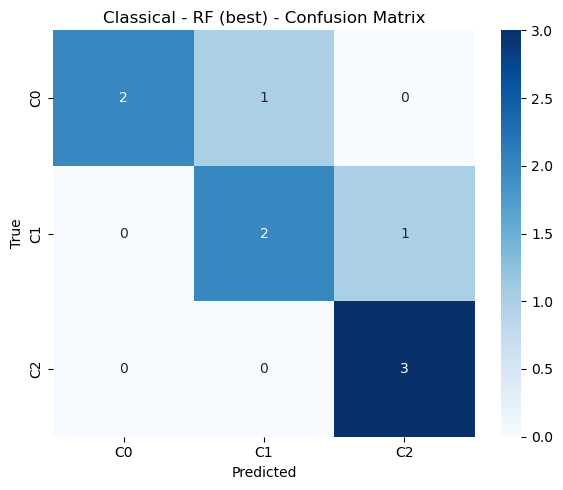

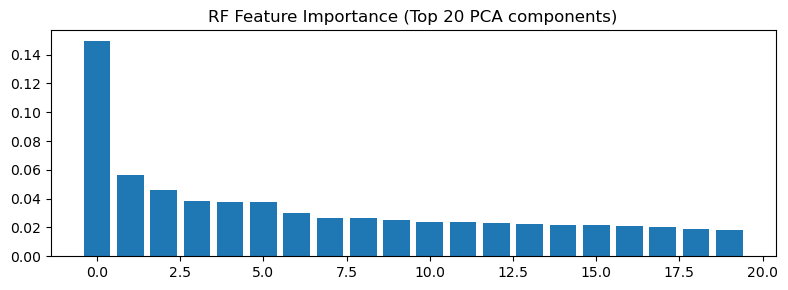

Fitting 3 folds for each of 24 candidates, totalling 72 fits
=== Classical - kNN (best) ===
Accuracy: 0.5555555555555556
Macro P/R/F1: 0.6666666666666666 0.5555555555555555 0.5222222222222223
Macro AUC: 0.6574074074074074


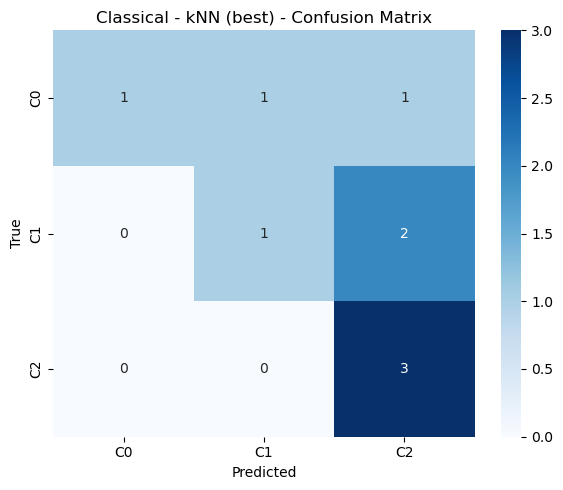

Classical models done: ['Classical-SVM', 'Classical-RF', 'Classical-kNN']


In [14]:
# Classical: features + PCA + train
X_train, y_train = build_Xy(train_c, DATA_ROOT_CLASSICAL, sampling=CLASSICAL_SAMPLING, cache_name='Xy_train_classical.npz')
X_val,   y_val   = build_Xy(val_c,   DATA_ROOT_CLASSICAL, sampling=CLASSICAL_SAMPLING, cache_name='Xy_val_classical.npz')
X_test,  y_test  = build_Xy(test_c,  DATA_ROOT_CLASSICAL, sampling=CLASSICAL_SAMPLING, cache_name='Xy_test_classical.npz')

prep, pca, Xtr_p, Xva_p, Xte_p = prep_and_pca(X_train, X_val, X_test, pca_var=0.95)

classical_results = train_classical_models(Xtr_p, y_train, Xte_p, y_test, N_CLASSES)
print('Classical models done:', list(classical_results.keys()))


In [15]:
# Deep: train (optional) and evaluate
TRAIN_DEEP = True

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

if TRAIN_DEEP:
    best_2d_avg,  tt_2d_avg  = train_deep_2d_variant(train_d, val_d, DATA_ROOT_DEEP, N_CLASSES, pooling='avg',  epochs=6)
    best_2d_max,  tt_2d_max  = train_deep_2d_variant(train_d, val_d, DATA_ROOT_DEEP, N_CLASSES, pooling='max',  epochs=6)
    best_2d_attn, tt_2d_attn = train_deep_2d_variant(train_d, val_d, DATA_ROOT_DEEP, N_CLASSES, pooling='attn', epochs=6)
    best_3d,      tt_3d      = train_deep_3d(train_d, val_d, DATA_ROOT_DEEP, N_CLASSES, epochs=6)
else:
    best_2d_avg  = os.path.join(CACHE_DIR, 'best_2d_avg.pt');  tt_2d_avg  = float('nan')
    best_2d_max  = os.path.join(CACHE_DIR, 'best_2d_max.pt');  tt_2d_max  = float('nan')
    best_2d_attn = os.path.join(CACHE_DIR, 'best_2d_attn.pt'); tt_2d_attn = float('nan')
    best_3d      = os.path.join(CACHE_DIR, 'best_3d_r3d18.pt'); tt_3d      = float('nan')

peak_gpu_mb = gpu_memory_report_mb()
print('Peak GPU MB:', peak_gpu_mb)

# Evaluate

deep_results = {}

m = EfficientNetTemporal(N_CLASSES, pooling='avg').to(DEVICE)
m.load_state_dict(torch.load(best_2d_avg, map_location=DEVICE))
ys, yp, pr, infer_s = eval_deep_2d(m, test_d, DATA_ROOT_DEEP)
met = deep_metrics_from_probs(ys, yp, pr, N_CLASSES)
size_mb, params = torch_model_size_mb(m)
deep_results['Deep-2D-Avg'] = {**met, 'train_time_s': tt_2d_avg, 'infer_time_s_per_video': infer_s,
                              'model_size_mb': size_mb, 'gpu_mem_mb': peak_gpu_mb, 'params': params}

m = EfficientNetTemporal(N_CLASSES, pooling='max').to(DEVICE)
m.load_state_dict(torch.load(best_2d_max, map_location=DEVICE))
ys, yp, pr, infer_s = eval_deep_2d(m, test_d, DATA_ROOT_DEEP)
met = deep_metrics_from_probs(ys, yp, pr, N_CLASSES)
size_mb, params = torch_model_size_mb(m)
deep_results['Deep-2D-Max'] = {**met, 'train_time_s': tt_2d_max, 'infer_time_s_per_video': infer_s,
                              'model_size_mb': size_mb, 'gpu_mem_mb': peak_gpu_mb, 'params': params}

m = EfficientNetTemporal(N_CLASSES, pooling='attn').to(DEVICE)
m.load_state_dict(torch.load(best_2d_attn, map_location=DEVICE))
ys, yp, pr, infer_s = eval_deep_2d(m, test_d, DATA_ROOT_DEEP)
met = deep_metrics_from_probs(ys, yp, pr, N_CLASSES)
size_mb, params = torch_model_size_mb(m)
deep_results['Deep-2D-Attn'] = {**met, 'train_time_s': tt_2d_attn, 'infer_time_s_per_video': infer_s,
                               'model_size_mb': size_mb, 'gpu_mem_mb': peak_gpu_mb, 'params': params}

m = build_r3d18(N_CLASSES).to(DEVICE)
m.load_state_dict(torch.load(best_3d, map_location=DEVICE))
ys, yp, pr, infer_s = eval_deep_3d(m, test_d, DATA_ROOT_DEEP)
met = deep_metrics_from_probs(ys, yp, pr, N_CLASSES)
size_mb, params = torch_model_size_mb(m)
deep_results['Deep-3D-R3D18'] = {**met, 'train_time_s': tt_3d, 'infer_time_s_per_video': infer_s,
                                'model_size_mb': size_mb, 'gpu_mem_mb': peak_gpu_mb, 'params': params}

print('Deep models done:', list(deep_results.keys()))


[2D-avg] ep 01 tr_acc=0.635 va_acc=0.797


[2D-avg] ep 02 tr_acc=0.819 va_acc=0.864


[2D-avg] ep 03 tr_acc=0.888 va_acc=0.932


[2D-avg] ep 04 tr_acc=0.863 va_acc=0.932


[2D-avg] ep 05 tr_acc=0.870 va_acc=0.949


[2D-avg] ep 06 tr_acc=0.917 va_acc=0.966


[2D-max] ep 01 tr_acc=0.498 va_acc=0.814


[2D-max] ep 02 tr_acc=0.700 va_acc=0.864


[2D-max] ep 03 tr_acc=0.794 va_acc=0.898


[2D-max] ep 04 tr_acc=0.812 va_acc=0.898


[2D-max] ep 05 tr_acc=0.834 va_acc=0.915


[2D-max] ep 06 tr_acc=0.899 va_acc=0.915


[2D-attn] ep 01 tr_acc=0.578 va_acc=0.881


[2D-attn] ep 02 tr_acc=0.801 va_acc=0.898


[2D-attn] ep 03 tr_acc=0.852 va_acc=0.915


[2D-attn] ep 04 tr_acc=0.895 va_acc=0.932


[2D-attn] ep 05 tr_acc=0.884 va_acc=0.949


[2D-attn] ep 06 tr_acc=0.946 va_acc=0.932


[3D-R3D18] ep 01 tr_acc=0.643 va_acc=0.915


[3D-R3D18] ep 02 tr_acc=0.758 va_acc=0.949


[3D-R3D18] ep 03 tr_acc=0.856 va_acc=0.898


[3D-R3D18] ep 04 tr_acc=0.903 va_acc=0.966


[3D-R3D18] ep 05 tr_acc=0.939 va_acc=0.966


[3D-R3D18] ep 06 tr_acc=0.942 va_acc=0.949
Peak GPU MB: 958.5732421875


Deep models done: ['Deep-2D-Avg', 'Deep-2D-Max', 'Deep-2D-Attn', 'Deep-3D-R3D18']


In [16]:
# Unified comparison table
all_results = {**classical_results, **deep_results}

rows = []
for name, d in all_results.items():
    rows.append({'model': name, **d})

df = pd.DataFrame(rows)
cols = ['model','accuracy','precision','recall','f1','macro_auc','train_time_s','infer_time_s_per_video','model_size_mb','gpu_mem_mb','params']
df = df[cols].sort_values(by='accuracy', ascending=False)

display(df)

metric_cols = ['accuracy','precision','recall','f1','macro_auc','infer_time_s_per_video','model_size_mb']
hib = {'infer_time_s_per_video': False, 'model_size_mb': False}
display(highlight_best(df, metric_cols, higher_is_better=hib))


,model,accuracy,precision,recall,f1,macro_auc,train_time_s,infer_time_s_per_video,model_size_mb,gpu_mem_mb,params
6,Deep-3D-R3D18,0.983333,0.983333,0.984127,0.983323,1.000000,2075.306861,1.245861,126.529064,958.573242,33168835.0
3,Deep-2D-Avg,0.966667,0.967460,0.967460,0.967033,0.999186,4429.371177,2.449194,15.312008,958.573242,4013951.0
5,Deep-2D-Attn,0.933333,0.937951,0.934127,0.933050,0.996725,4502.996409,2.429651,18.441895,958.573242,4834432.0
4,Deep-2D-Max,0.916667,0.917377,0.919048,0.916667,0.989321,4693.404328,2.438373,15.312008,958.573242,4013951.0
1,Classical-RF,0.777778,0.805556,0.777778,0.774603,0.898148,7.702600,0.002773,0.400132,0.000000,NaN
0,Classical-SVM,0.666667,0.666667,0.666667,0.657143,0.851852,4.512052,0.000019,0.020556,0.000000,NaN
2,Classical-kNN,0.555556,0.666667,0.555556,0.522222,0.657407,0.055737,0.036728,0.010653,0.000000,NaN


,model,accuracy,precision,recall,f1,macro_auc,train_time_s,infer_time_s_per_video,model_size_mb,gpu_mem_mb,params
6,Deep-3D-R3D18,0.983333,0.983333,0.984127,0.983323,1.000000,2075.306861,1.245861,126.529064,958.573242,33168835.000000
3,Deep-2D-Avg,0.966667,0.967460,0.967460,0.967033,0.999186,4429.371177,2.449194,15.312008,958.573242,4013951.000000
5,Deep-2D-Attn,0.933333,0.937951,0.934127,0.933050,0.996725,4502.996409,2.429651,18.441895,958.573242,4834432.000000
4,Deep-2D-Max,0.916667,0.917377,0.919048,0.916667,0.989321,4693.404328,2.438373,15.312008,958.573242,4013951.000000
1,Classical-RF,0.777778,0.805556,0.777778,0.774603,0.898148,7.702600,0.002773,0.400132,0.000000,nan
0,Classical-SVM,0.666667,0.666667,0.666667,0.657143,0.851852,4.512052,0.000019,0.020556,0.000000,nan
2,Classical-kNN,0.555556,0.666667,0.555556,0.522222,0.657407,0.055737,0.036728,0.010653,0.000000,nan


---

## 5) Efficiency plots


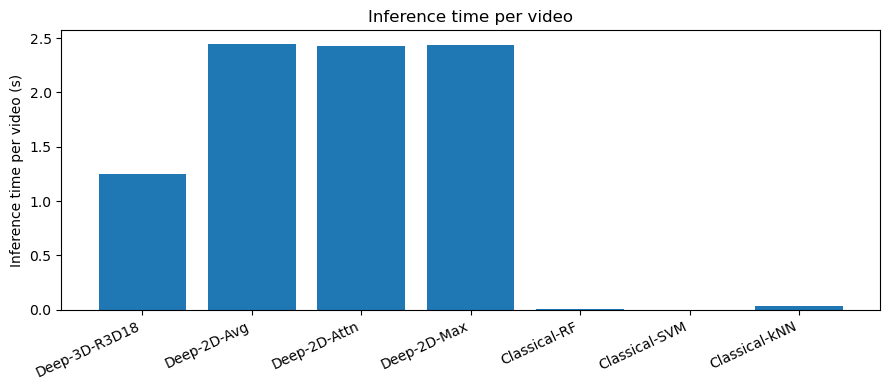

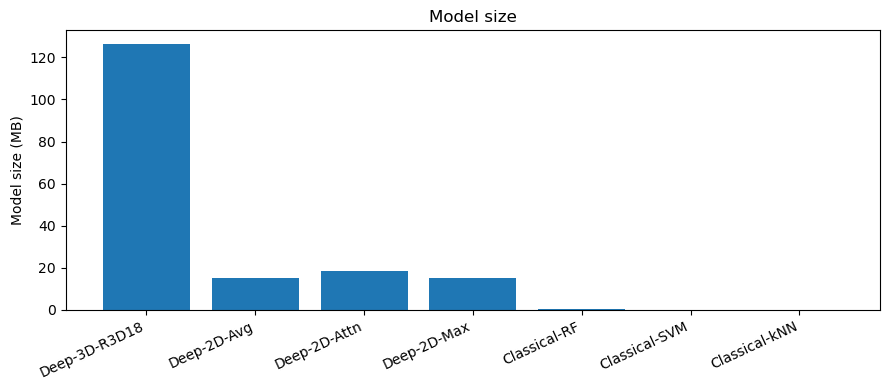

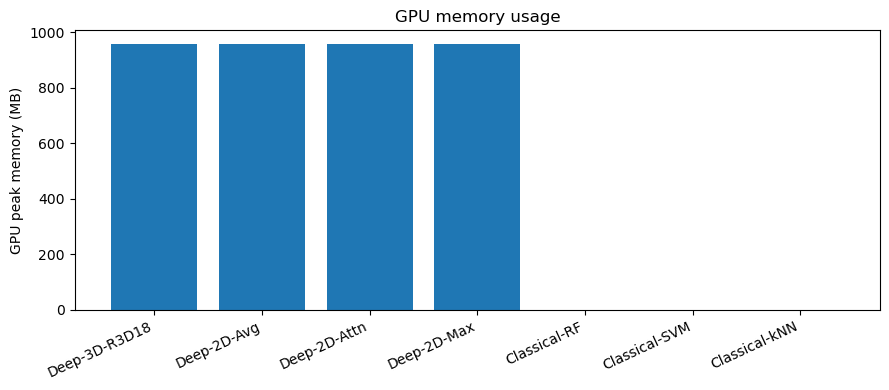

In [17]:
plt.figure(figsize=(9,4))
plt.bar(df['model'], df['infer_time_s_per_video'])
plt.xticks(rotation=25, ha='right')
plt.ylabel('Inference time per video (s)')
plt.title('Inference time per video')
plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.bar(df['model'], df['model_size_mb'])
plt.xticks(rotation=25, ha='right')
plt.ylabel('Model size (MB)')
plt.title('Model size')
plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.bar(df['model'], df['gpu_mem_mb'])
plt.xticks(rotation=25, ha='right')
plt.ylabel('GPU peak memory (MB)')
plt.title('GPU memory usage')
plt.tight_layout(); plt.show()


---

## 6) Data Efficiency: Learning Curves


In [18]:
def learning_curve_classical_rf(train_rows, test_rows, root, n_classes, fractions=(0.1,0.25,0.5,0.75,1.0)):
    out = []
    for frac in fractions:
        n = max(2, int(len(train_rows) * frac))
        sub = train_rows[:n]

        Xtr, ytr = build_Xy(sub, root, sampling=CLASSICAL_SAMPLING)
        Xte, yte = build_Xy(test_rows, root, sampling=CLASSICAL_SAMPLING)

        prep = Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', StandardScaler())])
        Xtr_s = prep.fit_transform(Xtr)
        Xte_s = prep.transform(Xte)
        pca = PCA(n_components=0.95, random_state=SEED)
        Xtr_p = pca.fit_transform(Xtr_s)
        Xte_p = pca.transform(Xte_s)

        rf = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)
        t0 = time.time(); rf.fit(Xtr_p, ytr); train_t = time.time()-t0
        t1 = time.time(); yp = rf.predict(Xte_p); infer_t = time.time()-t1

        out.append({'fraction': frac, 'n_train': n, 'acc': accuracy_score(yte, yp), 'f1': f1_score(yte, yp, average='macro'),
                    'train_time_s': train_t, 'infer_s_per_video': infer_t/len(yte)})
    return pd.DataFrame(out)

@torch.no_grad()
def quick_eval_deep(model, test_rows, root, is_3d=False):
    if is_3d:
        ys, yp, pr, infer_s = eval_deep_3d(model, test_rows, root)
    else:
        ys, yp, pr, infer_s = eval_deep_2d(model, test_rows, root)
    met = deep_metrics_from_probs(ys, yp, pr, N_CLASSES)
    return met['accuracy'], met['f1'], infer_s


def learning_curve_deep(train_rows, val_rows, test_rows, root, model_kind='2dmax', fractions=(0.1,0.25,0.5,0.75,1.0), epochs=3):
    out = []
    for frac in fractions:
        n = max(2, int(len(train_rows) * frac))
        sub = train_rows[:n]
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats()

        if model_kind == '2dmax':
            best_path, train_t = train_deep_2d_variant(sub, val_rows, root, N_CLASSES, pooling='max', epochs=epochs)
            model = EfficientNetTemporal(N_CLASSES, pooling='max').to(DEVICE)
            model.load_state_dict(torch.load(best_path, map_location=DEVICE))
            acc, f1m, infer_s = quick_eval_deep(model, test_rows, root, is_3d=False)
        elif model_kind == '3d':
            best_path, train_t = train_deep_3d(sub, val_rows, root, N_CLASSES, epochs=epochs)
            model = build_r3d18(N_CLASSES).to(DEVICE)
            model.load_state_dict(torch.load(best_path, map_location=DEVICE))
            acc, f1m, infer_s = quick_eval_deep(model, test_rows, root, is_3d=True)
        else:
            raise ValueError('model_kind must be 2dmax or 3d')

        out.append({'fraction': frac, 'n_train': n, 'acc': acc, 'f1': f1m,
                    'train_time_s': train_t, 'infer_s_per_video': infer_s, 'gpu_mem_mb': gpu_memory_report_mb()})

    return pd.DataFrame(out)


Built X,y: X=(5, 163828), y=(5,), time=5.5s
Built X,y: X=(9, 163828), y=(9,), time=10.9s
[uniform] processed 10/13
Built X,y: X=(13, 163828), y=(13,), time=17.6s
Built X,y: X=(9, 163828), y=(9,), time=10.9s
[uniform] processed 10/27
[uniform] processed 20/27
Built X,y: X=(27, 163828), y=(27,), time=34.7s
Built X,y: X=(9, 163828), y=(9,), time=11.0s
[uniform] processed 10/40
[uniform] processed 20/40
[uniform] processed 30/40
[uniform] processed 40/40
Built X,y: X=(40, 163828), y=(40,), time=50.5s
Built X,y: X=(9, 163828), y=(9,), time=10.9s
[uniform] processed 10/54
[uniform] processed 20/54
[uniform] processed 30/54
[uniform] processed 40/54
[uniform] processed 50/54
Built X,y: X=(54, 163828), y=(54,), time=67.4s
Built X,y: X=(9, 163828), y=(9,), time=11.0s


[2D-max] ep 01 tr_acc=0.407 va_acc=0.407


[2D-max] ep 02 tr_acc=0.519 va_acc=0.559


[2D-max] ep 01 tr_acc=0.406 va_acc=0.610


[2D-max] ep 02 tr_acc=0.609 va_acc=0.644


[2D-max] ep 01 tr_acc=0.486 va_acc=0.763


[2D-max] ep 02 tr_acc=0.739 va_acc=0.831


[2D-max] ep 01 tr_acc=0.531 va_acc=0.763


[2D-max] ep 02 tr_acc=0.686 va_acc=0.763


[2D-max] ep 01 tr_acc=0.516 va_acc=0.695


[2D-max] ep 02 tr_acc=0.708 va_acc=0.797


[3D-R3D18] ep 01 tr_acc=0.222 va_acc=0.627


[3D-R3D18] ep 02 tr_acc=0.852 va_acc=0.746


[3D-R3D18] ep 01 tr_acc=0.623 va_acc=0.847


[3D-R3D18] ep 02 tr_acc=0.696 va_acc=0.898


[3D-R3D18] ep 01 tr_acc=0.645 va_acc=1.000


[3D-R3D18] ep 02 tr_acc=0.761 va_acc=0.915


[3D-R3D18] ep 01 tr_acc=0.754 va_acc=0.864


[3D-R3D18] ep 02 tr_acc=0.773 va_acc=0.983


[3D-R3D18] ep 01 tr_acc=0.675 va_acc=0.915


[3D-R3D18] ep 02 tr_acc=0.747 va_acc=0.966


,fraction,n_train,acc,f1,train_time_s,infer_s_per_video
0,0.10,5,0.333333,0.166667,0.268616,0.002545
1,0.25,13,0.666667,0.555556,0.377744,0.002614
2,0.50,27,0.555556,0.444444,0.295773,0.002627
3,0.75,40,0.555556,0.516667,0.255242,0.002495
4,1.00,54,0.777778,0.774603,0.294506,0.002515


,fraction,n_train,acc,f1,train_time_s,infer_s_per_video,gpu_mem_mb
0,0.10,27,0.533333,0.537847,135.157205,2.441550,987.471680
1,0.25,69,0.783333,0.776613,343.931035,2.407752,1002.833008
2,0.50,138,0.783333,0.784594,671.869818,2.428129,1003.575195
3,0.75,207,0.683333,0.676932,998.255831,2.422793,1002.833008
4,1.00,277,0.800000,0.803283,1338.944527,2.393050,1002.833008


,fraction,n_train,acc,f1,train_time_s,infer_s_per_video,gpu_mem_mb
0,0.10,27,0.816667,0.816921,66.387860,1.238819,1086.623047
1,0.25,69,0.983333,0.982861,169.700792,1.238605,1212.297852
2,0.50,138,1.000000,1.000000,340.967781,1.236979,1213.360352
3,0.75,207,1.000000,1.000000,520.982300,1.248908,1213.516602
4,1.00,277,1.000000,1.000000,663.473481,1.177483,1214.235352


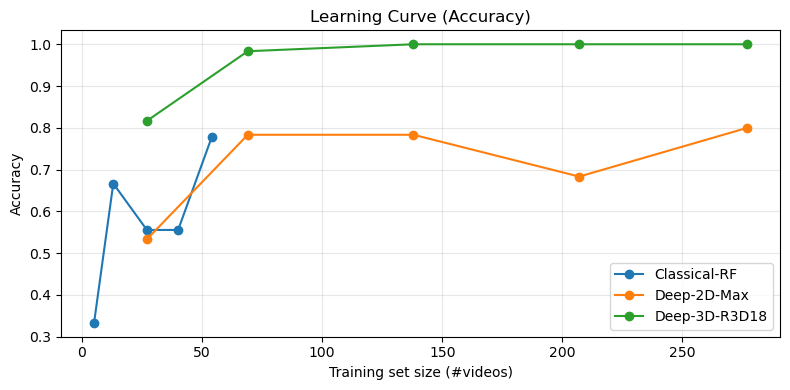

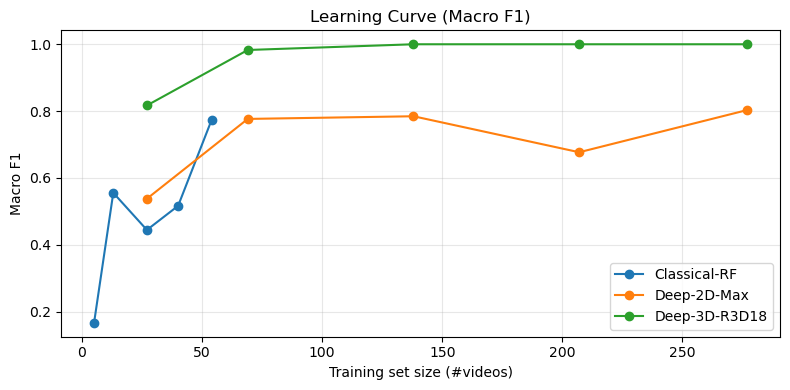

In [19]:
fractions = (0.1, 0.25, 0.5, 0.75, 1.0)

lc_rf = learning_curve_classical_rf(train_c, test_c, DATA_ROOT_CLASSICAL, N_CLASSES, fractions=fractions)
lc_2d = learning_curve_deep(train_d, val_d, test_d, DATA_ROOT_DEEP, model_kind='2dmax', fractions=fractions, epochs=2)
lc_3d = learning_curve_deep(train_d, val_d, test_d, DATA_ROOT_DEEP, model_kind='3d',    fractions=fractions, epochs=2)

display(lc_rf)
display(lc_2d)
display(lc_3d)

plt.figure(figsize=(8,4))
plt.plot(lc_rf['n_train'], lc_rf['acc'], marker='o', label='Classical-RF')
plt.plot(lc_2d['n_train'], lc_2d['acc'], marker='o', label='Deep-2D-Max')
plt.plot(lc_3d['n_train'], lc_3d['acc'], marker='o', label='Deep-3D-R3D18')
plt.xlabel('Training set size (#videos)'); plt.ylabel('Accuracy'); plt.title('Learning Curve (Accuracy)')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(lc_rf['n_train'], lc_rf['f1'], marker='o', label='Classical-RF')
plt.plot(lc_2d['n_train'], lc_2d['f1'], marker='o', label='Deep-2D-Max')
plt.plot(lc_3d['n_train'], lc_3d['f1'], marker='o', label='Deep-3D-R3D18')
plt.xlabel('Training set size (#videos)'); plt.ylabel('Macro F1'); plt.title('Learning Curve (Macro F1)')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


## 7) Strengths & Limitations

In [20]:
print('Strengths / Limitations (summary):')
print('- Classical: very small model binaries and fast classifier inference, but feature extraction can dominate end-to-end latency.')
print('- Deep: best accuracy (3D R3D-18 in reported run), but model sizes and GPU needs are higher.')
print('- Interpretability: classical features are human-interpretable; deep provides attention weights (2D-attn) and embedding plots.')
print('- Robustness: both pipelines applied denoise + sharpen; classical also computed blur/noise/blockiness, but dense flow is sensitive.')

Strengths / Limitations (summary):
- Classical: very small model binaries and fast classifier inference, but feature extraction can dominate end-to-end latency.
- Deep: best accuracy (3D R3D-18 in reported run), but model sizes and GPU needs are higher.
- Interpretability: classical features are human-interpretable; deep provides attention weights (2D-attn) and embedding plots.
- Robustness: both pipelines applied denoise + sharpen; classical also computed blur/noise/blockiness, but dense flow is sensitive.


## 8) Feature Space Visualizations (t-SNE / UMAP)
- Classical: PCA-space embeddings
- Deep: Logits embeddings (quick proxy)


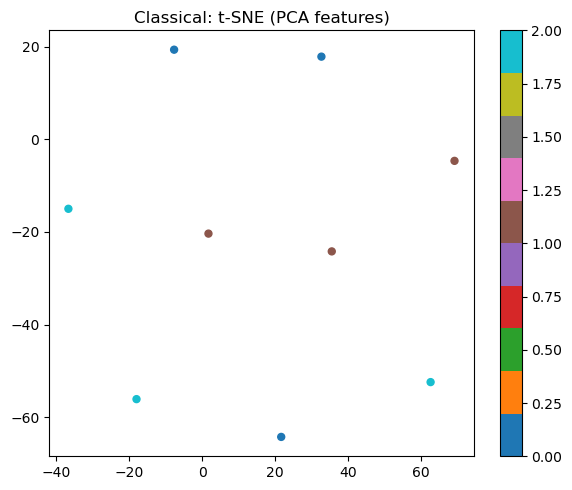

In [21]:
# Classical t-SNE on PCA features
X_embed = Xte_p
n_samples = X_embed.shape[0]
perplexity = max(2, min(30, n_samples - 1))

Z = TSNE(n_components=2, random_state=SEED, perplexity=perplexity, learning_rate='auto', init='pca').fit_transform(X_embed)
plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], c=y_test, cmap='tab10', s=25)
plt.title('Classical: t-SNE (PCA features)'); plt.colorbar(); plt.tight_layout(); plt.show()

DeepEmbeddings2D: 100%|██████████| 60/60 [02:19<00:00,  2.33s/it]


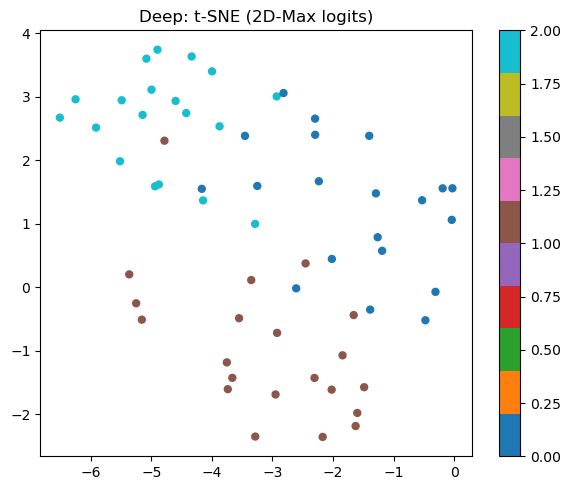

In [22]:
# Deep t-SNE/UMAP on logits for 2D-Max
@torch.no_grad()
def extract_deep_logits_2d(model, rows, root, max_videos=200):
    ds = FrameDataset2D(rows, root, num_frames=32, sampling=DEEP_SAMPLING)
    dl = DataLoader(ds, batch_size=1, shuffle=False)
    model.eval()
    embs, labs = [], []
    for i, (x, y) in enumerate(tqdm(dl, desc='DeepEmbeddings2D')):
        x = x.to(DEVICE)
        logits, _ = model(x)
        embs.append(logits.squeeze(0).cpu().numpy())
        labs.append(int(y.item()))
        if i+1 >= max_videos:
            break
    return np.array(embs), np.array(labs)

m = EfficientNetTemporal(N_CLASSES, pooling='max').to(DEVICE)
m.load_state_dict(torch.load(best_2d_max, map_location=DEVICE))
embs, labs = extract_deep_logits_2d(m, test_d, DATA_ROOT_DEEP, max_videos=200)

perplexity = max(2, min(30, len(embs)-1))
Z = TSNE(n_components=2, random_state=SEED, perplexity=perplexity, learning_rate='auto', init='pca').fit_transform(embs)
plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], c=labs, cmap='tab10', s=25)
plt.title('Deep: t-SNE (2D-Max logits)'); plt.colorbar(); plt.tight_layout(); plt.show()